# Advent of Code 2018

<div align="right"><i>Peter Norvig<br>December 2018</i></div>

Here are my solutions to [Advent of Code 2018](https://adventofcode.com/2018), following up on my solutions for [2017](Advent%202017.ipynb) and [2016](Advent%20of%20Code.ipynb). In order to understand each day's two-part puzzle, you'll need to click on the header links below (e.g. **[Day 1: Chronal Calibration](https://adventofcode.com/2018/day/1)**) and read the description. This year I didn't find time to race in real time when the puzzles are released; instead I'm doing batch processing, doing a couple of puzzles every few days. You can see I'm currently behind.


# Imports and Utility Functions

In [1]:
#### IMPORTS

%matplotlib inline
import matplotlib.pyplot as plt
import re
from collections import Counter, defaultdict, namedtuple, deque
from itertools   import chain, cycle, product, islice, count as count_from
from functools   import lru_cache, total_ordering
from dataclasses import dataclass

#### CONSTANTS

infinity = float('inf')
bignum   = 10 ** 100

#### FILE INPUT AND PARSING

def Input(day, line_parser=str.strip, file_template='data/advent2018/input{}.txt'):
    "For this day's input file, return a tuple of each line parsed by `line_parser`."
    return mapt(line_parser, open(file_template.format(day)))

def integers(text): 
    "A tuple of all integers in a string (ignore other characters)."
    return mapt(int, re.findall(r'-?\d+', text))

#### UTILITY FUNCTIONS

def mapt(fn, *args): 
    "Do a map, and make the results into a tuple."
    return tuple(map(fn, *args))

def first(iterable, default=None):
    "Return first item in iterable, or default."
    return next(iter(iterable), default)

def nth(iterable, n): return next(islice(iter(iterable), n, n+1))

cat = ''.join

def rangei(start, end, step=1):
    """Inclusive, range from start to end: rangei(a, b) = range(a, b+1)."""
    return range(start, end + 1, step) 

def quantify(iterable, pred=bool):
    "Count how many items in iterable have pred(item) true."
    return sum(map(pred, iterable))

def multimap(items):
    "Given (key, val) pairs, return {key: [val, ....], ...}."
    result = defaultdict(list)
    for (key, val) in items:
        result[key].append(val)
    return result

# [Day 1: Chronal Calibration](https://adventofcode.com/2018/day/1)

Part 1 was just a wordy way of saying "add up the input numbers." Part 2 requires cycling through the numbers multiple times, finding the partial sum (frequency) that first appears twice (that is, was seen before).

In [2]:
input1 = Input(1, int)

sum(input1)

466

In [3]:
assert _ == 466, 'Day 1.1'

In [4]:
# Part 2

def partial_sums(nums):
    "The sums of each prefix of nums."
    total = 0
    for n in nums:
        total += n
        yield total
        
def seen_before(items):
    "The first item that appears twice."
    seen = set()
    for item in items:
        if item in seen:
            return item
        seen.add(item)
        
seen_before(partial_sums(cycle(input1)))

750

In [5]:
assert _ == 750, 'Day 1.2'

# [Day 2: Inventory Management System](https://adventofcode.com/2018/day/7)

How many ids have a letter that appears exactly 2 times? 3 times?

In [6]:
input2 = Input(2)

def numwith(ids, n): return quantify(ids, lambda s: n in Counter(s).values())

numwith(input2, 2) * numwith(input2, 3)

8118

In [7]:
assert _ == 8118, 'Day 2.1'

Now, what letters are in common among the ids that differ in exactly one position?

In [8]:
# Part 2

def diff(A, B): return sum(a != b for a, b in zip(A, B))

def common(A, B): return cat(a for a,b in zip(A, B) if a == b)

common(*[i for i in input2 if any(diff(i, x) == 1 for x in input2)])

'jbbenqtlaxhivmwyscjukztdp'

In [9]:
assert _ == 'jbbenqtlaxhivmwyscjukztdp', 'Day 2.2'

# [Day 3: No Matter How You Slice It](https://adventofcode.com/2018/day/7)

In [10]:
input3 = Input(3, integers)

def claimed(claims):
    "For each square inch position (x, y), how many claims claimed it?"
    C = Counter()
    for (id, x, y, w, h) in claims:
        C += Counter(product(range(x, x+w), range(y, y+h)))
    return C

def value_ge(dic, threshold):
    "How many items in dic have a value >= threshold?"
    return quantify(dic[x] >= threshold for x in dic)

value_ge(claimed(input3), 2)

103806

In [11]:
assert _ == 103806, 'Day 3.1'

In [12]:
# Part 2

def claimed2(claims):
    "Which claim has only positions that are claimed by nobody else?"
    C = claimed(claims)
    for (id, x, y, w, h) in claims:
        if all(C[pos] == 1 for pos in product(range(x, x+w), range(y, y+h))):
            return id

claimed2(input3)

625

In [13]:
assert _ == 625, 'Day 3.2'

# [Day 4: Repose Record ](https://adventofcode.com/2018/day/7)

Find the guard that has the most minutes asleep, and the minute of the day that the guard spends asleep the most.

First make sure we can parse the log correctly:

In [14]:
example4 = '''[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up'''.splitlines()

def parse_record(text):
    "Return date, minutes, opcode action, and argument."
    text = re.sub('[][#:]', ' ', text)
    day, hour, mins, opcode, arg, *rest = text.split()
    return day, int(mins), opcode, arg

mapt(parse_record, example4)

(('1518-11-01', 0, 'Guard', '10'),
 ('1518-11-01', 5, 'falls', 'asleep'),
 ('1518-11-01', 25, 'wakes', 'up'),
 ('1518-11-01', 30, 'falls', 'asleep'),
 ('1518-11-01', 55, 'wakes', 'up'),
 ('1518-11-01', 58, 'Guard', '99'),
 ('1518-11-02', 40, 'falls', 'asleep'),
 ('1518-11-02', 50, 'wakes', 'up'),
 ('1518-11-03', 5, 'Guard', '10'),
 ('1518-11-03', 24, 'falls', 'asleep'),
 ('1518-11-03', 29, 'wakes', 'up'),
 ('1518-11-04', 2, 'Guard', '99'),
 ('1518-11-04', 36, 'falls', 'asleep'),
 ('1518-11-04', 46, 'wakes', 'up'),
 ('1518-11-05', 3, 'Guard', '99'),
 ('1518-11-05', 45, 'falls', 'asleep'),
 ('1518-11-05', 55, 'wakes', 'up'))

In [15]:
def timecard(log):
    "Return {guard: {day: [asleep_range, ...]}}."
    records = sorted(map(parse_record, log))
    sleep = defaultdict(lambda: defaultdict(list)) # sleep[guard][day] = [minute, ...]
    for day, mins, opcode, arg in records:
        if opcode == 'Guard':
            guard = int(arg)
        elif opcode == 'falls':
            falls = mins
        elif opcode == 'wakes':
            wakes = mins
            sleep[guard][day].extend(range(falls, wakes))
        else:
            error()
    return sleep
    
timecard(example4)[99] # Guard 99's sleep record

defaultdict(list,
            {'1518-11-02': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             '1518-11-04': [36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
             '1518-11-05': [45, 46, 47, 48, 49, 50, 51, 52, 53, 54]})

In [16]:
def sleepiest_guard(sleep):
    "Which guard sleeps the most minutes?"
    return max(sleep, key=lambda guard: sum(map(len, sleep[guard].values())))

def sleepiest_minute(guard, sleep):
    "In which minute is this guard asleep the most?"
    def times_asleep(m): return sum(m in mins for mins in sleep[guard].values())
    return max(range(60), key=times_asleep)

def repose(lines):
    "The ID of the sleepiest guard times that guard's sleepiest minute."
    sleep = timecard(lines)
    guard = sleepiest_guard(sleep)
    minute = sleepiest_minute(guard, sleep)
    return guard * minute

repose(Input(4))

143415

In [17]:
assert _ == 143415, 'Day 4.1'

In [18]:
# Part 2

def repose2(lines):
    """Of all guards, which guard is most frequently asleep on the same minute?
    What is the ID of the guard you chose multiplied by the minute you chose?"""
    sleep = timecard(lines)
    c = Counter((guard, minute) for guard in sleep
                                for minute in chain(*sleep[guard].values()))
    [((guard, minute), _)] = c.most_common(1)
    return guard * minute

repose2(Input(4))

49944

In [19]:
assert _ == 49944, 'Day 4.2'

# [Day 5: Alchemical Reduction](https://adventofcode.com/2018/day/5)

How many units remain after fully reacting the polymer you scanned? Reacting means removing `Cc` and `cC`, etc.

In [20]:
input5 = cat(Input(5))

alphabet = 'abcdefghijklmnopqrstuvwxyz'
ALPHABET = alphabet.upper()

OR = '|'.join
reaction = OR(OR([c + C, C + c]) for c, C in zip(alphabet, ALPHABET))

def reduction(text):
    "Remove all cC or Cc pairs, and repeat."
    while True:
        text, n = re.subn(reaction, '', text)
        if n == 0:
            return text
        
reduction('dabAcCaCBAcCcaDA')

'dabCBAcaDA'

In [21]:
len(reduction(input5))

10180

In [22]:
assert _ == 10180, 'Day 5.1'

In [23]:
# Part 2

def shortest(items): return min(items, key=len)

def reduction2(text):
    """What is the length of the shortest polymer you can produce by removing 
    all units of exactly one type and fully reacting the result?"""
    return shortest(reduction(re.sub(c, '', text, flags=re.I))
                    for c in alphabet)

len(reduction2(input5))

5668

In [24]:
assert _ == 5668, 'Day 5.2'

# [Day 6: Chronal Coordinates](https://adventofcode.com/2018/day/6)

Given a set of pointson a grid (all positive integer (x, y) coordinates), each point defines an *area* of grid points that are closer to it than any other point in the set (i.e. the Voronoi diagram). What is the size of the largest area (measured in number of grid points) that isn't infinite?  To answer, use a `Counter` over grid points in the bounding box that covers all the input points. 

Originally, I thought that if a point on the perimeter of the box was closest to point `p`, then `p` has an infinite area. That's true for `p` that are in the corners, but need not be true for all `p` (consider a set of 5 points, 4 in the corners of a box, and one near the center; the center point will have a diamond-shaped area, and unless it is at the exact center, it will "leak" outside one of the edges). So I expand the bounding box by a margin. I make a guess at the necessary margin size, so my answer might not always be correct, but hey, it worked for the input I was given.

In [25]:
input6 = Input(6, integers)

def closest_to(point, points):
    "Which of `points` is closest to `point`? Return None if tie."
    p1, p2 = sorted(points, key=lambda p: distance(p, point))[:2]
    return p1 if distance(p1, point) < distance(p2, point) else None

def X(point): return point[0]
def Y(point): return point[1]
def distance(p, q): return abs(X(p) - X(q)) + abs(Y(p) - Y(q))
def maxval(dic): return max(dic.values())

def closest_counts(points, margin=100):
    "What is the size of the largest area of closest points that isn't infinite?"
    assert len(points) > 1
    xside  = range(-margin, max(map(X, points)) + margin)
    yside  = range(-margin, max(map(Y, points)) + margin)
    box    = product(xside, yside)
    # counts[point] = number of grid points in box that are closest to point
    counts = Counter(closest_to(p, points) for p in box)
    # Now delete the counts that are suspected to be infinite:
    for p in perimeter(xside, yside):
        c = closest_to(p, points)
        if c in counts:
            del counts[c]
    return counts

def perimeter(xside, yside):
    "The perimeter of a box with these sides."
    return chain(((xside[0], y)  for y in yside),
                 ((xside[-1], y) for y in yside),
                 ((x, yside[0])  for x in xside),
                 ((x, yside[-1]) for x in xside))
        
closest_counts([(1, 1), (1, 6), (8, 3), (3, 4), (5, 5), (8, 9)])  

Counter({(3, 4): 9, (5, 5): 17})

In [26]:
maxval(closest_counts(input6))

3010

In [27]:
assert _ == 3010, 'Day 6.1'

In [28]:
# Part 2

def total_distance(point, points):
    "Total distance of this point to all the `points`."
    return sum(distance(point, c) for c in points)

def neighborhood(points, dist=10000):
    """What is the size of the region containing all locations which have a  
    total distance to all given points of less than `dist`?"""
    maxx = max(x for x,y in points)
    maxy = max(y for x,y in points)
    box  = product(range(maxx + 1), range(maxy + 1))
    return quantify(box, lambda p: total_distance(p, points) < dist)

In [29]:
neighborhood(Input(6, integers))

48034

In [30]:
assert _ == 48034, 'Day 6.2'

# [Day 7: The Sum of Its Parts](https://adventofcode.com/2018/day/7)

Given instructions like `Step B must be finished before step A can begin`, in what order should the steps be completed? When several steps are possible, do the alphabetically first (`min`) first.


In [31]:
def parse_instruction(line): return re.findall(' ([A-Z]) ', line)

parse_instruction('Step B must be finished before step A can begin.')

['B', 'A']

In [32]:
input7 = Input(7, parse_instruction)

def order(pairs):
    "Yield steps in order, respecting (before, after) pairs; break ties lexically."
    steps = {step for pair in pairs for step in pair} # Steps remaining to be done
    prereqs = multimap((A, B) for [B, A] in pairs)    # prereqs[A] = [B, ...]
    def ready(step): return all(pre not in steps for pre in prereqs[step])
    while steps:
        step = min(filter(ready, steps))   
        steps.remove(step)
        yield step
        
cat(order(input7))

'ABGKCMVWYDEHFOPQUILSTNZRJX'

In [33]:
assert _ == 'ABGKCMVWYDEHFOPQUILSTNZRJX', 'Day 7.1'

In part 2 I need to schedule each step; I'll keep track of `endtime[step]` as a time step (initially infinitely far in the future). I'll also keep track of the number of available workers, decrementing the count when I assign a step to a worker, and incrementing the count when a step is completed.

In [34]:
# Part 2

def schedule(pairs, workers=5):
    "Return a {step:endtime} map for best schedule, given a number of `workers`."
    steps = {step for pair in pairs for step in pair} # Steps remaining to be done
    prereqs = multimap((A, B) for (B, A) in pairs)    # prereqs[A] = [B, ...]
    endtime = {step: infinity for step in steps}      # endtime[step] = time it will be completed
    for t in count_from(0): 
        # Assign available steps to free workers
        def ready(step): return all(endtime[p] < t for p in prereqs[step])
        available = filter(ready, steps)
        for step in sorted(available)[:workers]:
            endtime[step] = t + 60 + ord(step) - ord('A')
            steps.remove(step)
            workers -= 1
        # Discover if any workers become free this time step
        workers += quantify(endtime[step] == t for step in endtime)
        # Return answer once all steps have been scheduled
        if not steps:
            return endtime

In [35]:
schedule(input7)

{'U': 354,
 'I': 423,
 'M': 133,
 'X': 897,
 'K': 132,
 'W': 144,
 'J': 813,
 'T': 503,
 'D': 259,
 'B': 61,
 'P': 408,
 'L': 426,
 'E': 198,
 'O': 273,
 'A': 60,
 'F': 332,
 'Y': 84,
 'C': 195,
 'V': 215,
 'Z': 665,
 'S': 505,
 'G': 66,
 'H': 266,
 'N': 579,
 'Q': 350,
 'R': 743}

In [36]:
maxval(schedule(input7)) + 1

898

In [37]:
assert _ == 898, 'Day 7.2'

# [Day 8: Memory Maneuver](https://adventofcode.com/2018/day/8)

I'll handle the list of numbers as a `deque` (so I can efficiently pop from the left), and I'll create a `Tree` data structure with `metadata` and `kids` (children) fields.

In [38]:
input8 = integers(cat(Input(8)))
                  
Tree = namedtuple('Tree', 'kids, metadata')

def tree(nums):
    """A node consists of the numbers: [k, n, (k child nodes)..., (n metadata values)...]."""
    k, n = nums.popleft(), nums.popleft()
    return Tree([tree(nums) for _ in range(k)], 
                [nums.popleft() for _ in range(n)])

example8 = tree(deque((2, 3, 0, 3, 10, 11, 12, 1, 1, 0, 1, 99, 2, 1, 1, 2)))
tree8    = tree(deque(input8))

In [39]:
def sum_metadata(tree):
    "What is the sum of all metadata entries in a tree?"
    return sum(tree.metadata) + sum(map(sum_metadata, tree.kids))

sum_metadata(example8)

138

In [40]:
sum_metadata(tree8)

48443

In [41]:
assert _ == 48443, 'Day 8.1'

In [42]:
def value(tree):
    """What is the value of the root node? 
    Value of tree with no kids is sum of metadata; 
    Otherwise metadata are 1-based indexes into kids; sum up their values."""
    if not tree.kids:
        return sum(tree.metadata)
    else:
        return sum(value(tree.kids[i - 1]) 
                   for i in tree.metadata 
                   if i <= len(tree.kids))        

In [43]:
value(example8)

66

In [44]:
value(tree8)

30063

In [45]:
assert _ == 30063, 'Day 8.2'

# [Day 9: Marble Mania](https://adventofcode.com/2018/day/9)

I'll represent the circle as a `deque` (so I can `rotate`). I had a couple of off-by-one errors, due in part to the problem being 1-based not 0-based, so I put in the `verbose` option; in my verbose output (unlike the problem description), the circle always starts with the position after the "current" position, and the newly-inserted marble is always last.

In [46]:
players, marbles = integers('448 players; last marble is worth 71628 points')

def play(players, marbles, verbose=False):
    "Add `marbles` to `circle`, rotating according to rules and scoring every 23 marbles."
    circle = deque([0])
    scores = Counter()
    for m in rangei(1, marbles):
        player = (m - 1) % players + 1
        if m % 23:
            circle.rotate(-1)
            circle.append(m)
        else:
            circle.rotate(+7)
            scores[player] += circle.pop() + m
            circle.rotate(-1)
        if verbose: print(player, list(circle))
    return scores

play(9, 25, True)

1 [0, 1]
2 [1, 0, 2]
3 [0, 2, 1, 3]
4 [2, 1, 3, 0, 4]
5 [1, 3, 0, 4, 2, 5]
6 [3, 0, 4, 2, 5, 1, 6]
7 [0, 4, 2, 5, 1, 6, 3, 7]
8 [4, 2, 5, 1, 6, 3, 7, 0, 8]
9 [2, 5, 1, 6, 3, 7, 0, 8, 4, 9]
1 [5, 1, 6, 3, 7, 0, 8, 4, 9, 2, 10]
2 [1, 6, 3, 7, 0, 8, 4, 9, 2, 10, 5, 11]
3 [6, 3, 7, 0, 8, 4, 9, 2, 10, 5, 11, 1, 12]
4 [3, 7, 0, 8, 4, 9, 2, 10, 5, 11, 1, 12, 6, 13]
5 [7, 0, 8, 4, 9, 2, 10, 5, 11, 1, 12, 6, 13, 3, 14]
6 [0, 8, 4, 9, 2, 10, 5, 11, 1, 12, 6, 13, 3, 14, 7, 15]
7 [8, 4, 9, 2, 10, 5, 11, 1, 12, 6, 13, 3, 14, 7, 15, 0, 16]
8 [4, 9, 2, 10, 5, 11, 1, 12, 6, 13, 3, 14, 7, 15, 0, 16, 8, 17]
9 [9, 2, 10, 5, 11, 1, 12, 6, 13, 3, 14, 7, 15, 0, 16, 8, 17, 4, 18]
1 [2, 10, 5, 11, 1, 12, 6, 13, 3, 14, 7, 15, 0, 16, 8, 17, 4, 18, 9, 19]
2 [10, 5, 11, 1, 12, 6, 13, 3, 14, 7, 15, 0, 16, 8, 17, 4, 18, 9, 19, 2, 20]
3 [5, 11, 1, 12, 6, 13, 3, 14, 7, 15, 0, 16, 8, 17, 4, 18, 9, 19, 2, 20, 10, 21]
4 [11, 1, 12, 6, 13, 3, 14, 7, 15, 0, 16, 8, 17, 4, 18, 9, 19, 2, 20, 10, 21, 5, 22]
5 [2, 20, 10, 21, 

Counter({5: 32})

In [47]:
maxval(play(players, marbles))

394486

In [48]:
assert _ == 394486, 'Day 9.1'

In [49]:
maxval(play(players, marbles * 100))

3276488008

In [50]:
assert _ == 3276488008, 'Day 9.2'

# [Day 10: The Stars Align](https://adventofcode.com/2018/day/10)


The basic idea of moving objects into a new configuration is easy: increment their position by their velocity to get a set of points. The hard part is figuring out when they spell a message. My assumption is that the lights are initially spread far afield; over time they will come together into a central location; then they will overshoot and go off in the other direction. My even bigger (but still resonable) assumption is that the message is spelled when the area of the bounding box of the points is a minimum. When that happens, I'll just print the configuration, and read what is there. (I won't write code to do OCR.)

In [51]:
Light = namedtuple('Light', 'x, y, dx, dy')

input10 = Input(10, lambda line: Light(*integers(line)))

def configuration(t, lights=input10):
    "The positions of the lights at time t."
    return {(L.x + t * L.dx, L.y + t * L.dy) for L in lights}
        
def bounds(points):
    "Return xmin, xmax, ymin, ymax of the bounding box."
    return (min(map(X, points)), max(map(X, points)),
            min(map(Y, points)), max(map(Y, points)))

def extent(points):
    "Area of bounding box."
    xmin, xmax, ymin, ymax = bounds(points)
    return (xmax - xmin) * (ymax - ymin)

def localmin(sequence, key):
    "Iterate through sequence, when key(item) starts going up, return previous item."
    prevscore = infinity
    for item in sequence:
        score = key(item)
        if prevscore < score:
            return prev
        prev, prevscore = item, score
        
def lightshow(points, chars='.#'):
    "Print out the locations of the points."
    xmin, xmax, ymin, ymax = bounds(points)
    for y in rangei(ymin, ymax):
        print(cat(chars[(x, y) in points] for x in rangei(xmin, xmax)))

In [52]:
configurations = map(configuration, count_from(0))
lights = localmin(configurations, key=extent)
lightshow(lights)

#####...#....#.....###..#....#.....###....##....######..#....#
#....#..#....#......#...#....#......#....#..#...#.......#....#
#....#...#..#.......#....#..#.......#...#....#..#........#..#.
#....#...#..#.......#....#..#.......#...#....#..#........#..#.
#####.....##........#.....##........#...#....#..#####.....##..
#....#....##........#.....##........#...######..#.........##..
#....#...#..#.......#....#..#.......#...#....#..#........#..#.
#....#...#..#...#...#....#..#...#...#...#....#..#........#..#.
#....#..#....#..#...#...#....#..#...#...#....#..#.......#....#
#####...#....#...###....#....#...###....#....#..######..#....#


That should be "`BXJXJAEX`".

In Part 2 I need to get the time `t` at which we generate the configuration `lights`:

In [53]:
# Part 2

next(t for t in count_from(1) if configuration(t) == lights)

10605

In [54]:
assert _ == 10605

# [Day 11: Chronal Charge](https://adventofcode.com/2018/day/11)

In [55]:
serial = input11 = 6303

def power_level(point):
    "Follow the rules for power level."
    id = X(point) + 10
    level = (id * Y(point) + serial) * id
    return (level // 100) % 10 - 5

def total_power(topleft, width=3):
    "Total power in the square with given topleft corner and width."
    x, y = topleft
    square = product(range(x, x + width), range(y, y + width))
    return sum(map(power_level, square))

def maxpower(bounds=300, width=3):
    "Return (power, topleft, width) of square within `bounds` of maximum power."
    toplefts = product(rangei(1, bounds - width), repeat=2)
    return max((total_power(topleft, width), topleft, width)
               for topleft in toplefts)

maxpower()

(30, (243, 27), 3)

In [56]:
assert _[1] == (243, 27), 'Day 11.1'

To enumerate all the squares of any width is O(<i>n</i><sup>4</sup>); too much when *n* = 300. So I'll refactor `total_power` to cache results in a summed-area table (a standard approach from computer graphics).

In [57]:
# Part 2

def summed_area(side, key):
    "A summed-area table."
    I = defaultdict(int)
    for x, y in product(side, side):
        I[x, y] = key((x, y)) + I[x, y - 1] + I[x - 1, y] - I[x - 1, y - 1]
    return I

def total_power(topleft, width=3, I=summed_area(rangei(1, 300), power_level)):
    "Total power in square with given topleft corner and width (from `I`)."
    x, y = topleft
    xmin, ymin, xmax, ymax = x - 1, y - 1, x + width - 1, y + width - 1
    return I[xmin, ymin] + I[xmax, ymax] - I[xmax, ymin] - I[xmin, ymax]

# Make sure we get the same answer for the Part 1 problem
assert maxpower() == (30, (243, 27), 3)

In [58]:
max(maxpower(width=w) for w in range(300))

(88, (284, 172), 12)

In [59]:
assert _[1] + _[2:] == (284, 172, 12), 'Day 11.2'

# [Day 12: Subterranean Sustainability](https://adventofcode.com/2018/day/12)

One-dimensional cellular automata. Fun! AT first I thought I would represent a row of plants as a string, but I realized I'd also need to track the start position of the string, so I decided it was easier to represent a row of plants as a set of index numbers of pots that are live. I'll make `grow()` yield all future generations:

In [60]:
def Plants(row):
    "Convert '#..#.#' => {0, 3, 5}"
    return {i for i, c in enumerate(row) if c == '#'}

input12 = Input(12, str.split)
plants  = Plants(input12[0][-1])
rules   = {rule[0]: rule[-1] for rule in input12 if '=>' in rule}

def grow(plants=plants, rules=rules):
    "Grow plants using rules, yielding each generation (including 0th)."
    while True:
        yield plants
        extent = rangei(min(plants) - 3, max(plants) + 3)
        plants = {i for i in extent if lives(plants, i, rules)}

def lives(plants, i, rules):
    "Does pot i live in next generation, according to rules?"
    neighborhood = cat('.#'[j in plants] for j in rangei(i - 2, i + 2))
    return rules[neighborhood] == '#'

sum(nth(grow(), 20))

1447

In [61]:
assert _ == 1447, 'Day 12.1' 

Cool, my answer is leet-er than `1337`. But Part 2, asks for 50 billion generations. Maybe the pattern reaches a fixed point, or cycles, like the blinker in Conway's Life game. Let's plot the number of plants, and their sums, over the first couple hundred generations and see if there is a pattern:

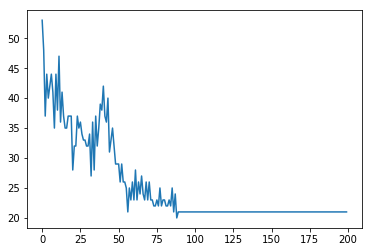

In [62]:
# Part 2

gens = list(islice(grow(), 200))
plt.plot(mapt(len, gens), label='x');

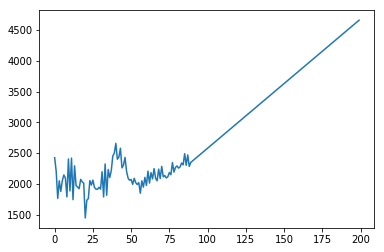

In [63]:
plt.plot(mapt(sum, gens));

OK, no problem: after a while the sum settles down and grows at a constant rate. I can figure out what that rate is:

In [64]:
[sum(plants) for plants in gens[100:103]]

[2580, 2601, 2622]

It is growing by 21 each time. So my answer should be 2580 + 21 × (50 billion - 100). More generally:

In [65]:
def nth_plant_sum(n, k=100):
    "The sum of plants in the nth generation, assuming linear growth after k generations."
    a, b = map(sum, islice(grow(), k, k + 2))
    return a + (n - k) * (b - a)

nth_plant_sum(50 * 10 ** 9)

1050000000480

In [66]:
assert _ == 1050000000480, 'Day 12.2'

Now, *why* does it grow by 21 each time? Well, we saw in the plot of lengths above that the length eventually remains constant; we can see the last few:

In [67]:
[len(g) for g in gens[-3:]]

[21, 21, 21]

There are 21 plants in each generation; here is one generation:

In [68]:
gens[100]

{59,
 60,
 61,
 71,
 72,
 73,
 84,
 85,
 86,
 137,
 138,
 139,
 149,
 150,
 151,
 159,
 160,
 161,
 194,
 195,
 196}

We see that the plants are bunched into groups of three. What happens to a group of three?

In [69]:
dict(zip(range(6), grow(plants={1, 2, 3})))

{0: {1, 2, 3},
 1: {2, 3, 4},
 2: {3, 4, 5},
 3: {4, 5, 6},
 4: {5, 6, 7},
 5: {6, 7, 8}}

They move one to the right each generation; moving 7  groups of 3 one to the right results in adding 21 to the sum.

# [Day 13: Mine Cart Madness](https://adventofcode.com/2018/day/13)

I need to do the following:

- Parse the picture of the world into a data structure.
- Keep track of the carts, and have them make the right moves. 
- Continue until there is a collision.

Since this has to do with headings and turns, I'm going to use complex numbers to represent points, headings, and turns; multiplying a complex heading by a complex turn results in a new heading. Then adding the heading to a point results in a new point. I'll redefine the `X` and `Y` accessors to handle either the complex points used here or the tuple points used previously:

In [70]:
Point = complex

def X(point):  return point.real if isinstance(point, complex) else point[0]
def Y(point):  return point.imag if isinstance(point, complex) else point[1]

# Headings: HU, HD, HR, HL = Head up, down, right, left
# Turns:    TL, TR, TS, TB = Turn left, right, straight, backwards
HU = TL = Point(0, -1)
HD = TR = -TL
HR = TS = Point(1, 0)
HL = TB = -TS

headings = {'>': HR, '<': HL, '^': HU, 'v': HD}
inverse_headings = dict((headings[ch], ch) for ch in headings)

assert HU * TR == HR and TR ** 4 == TL ** 4 == TS and HR * TB == HL and HU == -HD and TR == -TL

Now we need to define a `Cart`, and the `World` they will live in. We use the [`dataclass`](https://docs.python.org/3/library/dataclasses.html) facility from Python 3.

In [71]:
@dataclass
class Cart:
    name: str
    pos: Point
    heading: Point
    turns: object
        
@dataclass
class World:
    grid: tuple
    carts: list

    def __init__(self, lines):
        table      = str.maketrans('<>^v', '--||')
        names      = cycle(alphabet)
        self.grid  = [line.translate(table) for line in lines]
        self.carts = [Cart(next(names), Point(x, y), headings[h], cycle((TL, TS, TR)))
                      for (y, line) in enumerate(lines)
                      for (x, h) in enumerate(line)
                      if h in headings]
        
    def __getitem__(self, point): return self.grid[int(Y(point))][int(X(point))]
    
    def show(self):
        "Print a representation of the world."
        for y, line in enumerate(self.grid):
            for x, ch in enumerate(line):
                cart = first(c for c in self.carts if c.pos == Point(x, y))
                ch = inverse_headings[cart.heading] if cart else ch
                print(ch, end='')
            print()
        print()

Now the function `madmad(world)`, which simulates moving the carts until a collision.

In [72]:
def madmad(world, show=False):
    "Simulate the mine cart madness until a collision."
    while True:
        if show: world.show()
        for cart in sorted(world.carts, key=lambda c: (Y(c.pos), X(c.pos))):
            cart.heading *= turn(cart, world)
            cart.pos += cart.heading
            if collision(cart, world):
                if show: world.show()
                return cart.pos

def turn(cart, world):
    "Which way should the cart turn (depends on character it is on)."
    ch = world[cart.pos]
    if ch == '+':
        return next(cart.turns) 
    if ch == '/':
        return (TR if cart.heading in (HU, HD) else TL)
    if ch == '\\': 
        return (TR if cart.heading in (HR, HL) else TL)
    else:
        return TS
    
def collision(cart, world):
    "Has this cart collided with any other cart?"
    return any(cart.pos == other.pos for other in world.carts if other is not cart)

In [73]:
example = r'''
/->-\         
|   |  /----\ 
| /-+--+-\  | 
| | |  | v  | 
\-+-/  \-+--/ 
  \------/     
'''.strip().splitlines()

madmad(World(example), True)

/->-\         
|   |  /----\ 
| /-+--+-\  | 
| | |  | v  | 
\-+-/  \-+--/ 
  \------/

/-->\         
|   |  /----\ 
| /-+--+-\  | 
| | |  | |  | 
\-+-/  \-v--/ 
  \------/

/--->         
|   |  /----\ 
| /-+--+-\  | 
| | |  | |  | 
\-+-/  \-+>-/ 
  \------/

/---\         
|   v  /----\ 
| /-+--+-\  | 
| | |  | |  | 
\-+-/  \-+->/ 
  \------/

/---\         
|   |  /----\ 
| /-v--+-\  | 
| | |  | |  | 
\-+-/  \-+--> 
  \------/

/---\         
|   |  /----\ 
| /-+>-+-\  | 
| | |  | |  ^ 
\-+-/  \-+--/ 
  \------/

/---\         
|   |  /----\ 
| /-+->+-\  ^ 
| | |  | |  | 
\-+-/  \-+--/ 
  \------/

/---\         
|   |  /----^ 
| /-+-->-\  | 
| | |  | |  | 
\-+-/  \-+--/ 
  \------/

/---\         
|   |  /---<\ 
| /-+--+>\  | 
| | |  | |  | 
\-+-/  \-+--/ 
  \------/

/---\         
|   |  /--<-\ 
| /-+--+->  | 
| | |  | |  | 
\-+-/  \-+--/ 
  \------/

/---\         
|   |  /-<--\ 
| /-+--+-\  | 
| | |  | v  | 
\-+-/  \-+--/ 
  \------/

/---\         
|   |  /<---\ 
| /-+--+-\  |

(7+3j)

The answer, `7, 3`, is correct, and everything looks good!

Unfortunately, I got an error when trying it on the actual (larger) input.

Even more unfortunately, I ran out of spare time to debug this problem and to move on to the remaining days. Maybe next year!

In [74]:
madmad(World(Input(13)))

IndexError: string index out of range